In [1]:
using PyCall

In [2]:
using PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN

In [3]:
using Parameters

In [67]:
using ObjectLearning: VoxelGrid, shape_model, ShapeModelParams, SCALE

[ Info: Precompiling ObjectLearning [a21d6863-a99d-4c79-a19f-ed6f78174c87]


In [5]:
using Gen

In [6]:
import Gen: random, logpdf

In [7]:
using Rotations

In [9]:
j = pyimport("jax3dp3");

In [10]:
jax = pyimport("jax");

In [11]:
jnp = pyimport("jax.numpy");

In [12]:
np = pyimport("numpy");

In [13]:
trimesh = pyimport("trimesh");

In [14]:
Intrinsics = @NamedTuple begin
    height::Int64
    width::Int64
    fx::Float64
    fy::Float64
    cx::Float64
    cy::Float64
    near::Float64
    far::Float64
end;

In [15]:
intrinsics = Intrinsics((height=300, width=300,
           fx=200.0, fy=200.0,
           cx=150.0, cy=150.0,
           near=0.001, far=50.0));

In [16]:
struct JAXRenderer
    pyobj::PyObject
end

In [17]:
struct Mesh
    pyobj::PyObject
end

In [18]:
make_renderer(intrinsics::Intrinsics) = JAXRenderer(j.Renderer(intrinsics))

make_renderer (generic function with 1 method)

In [19]:
function load_ycb_mesh(idx::Int; scale=1000.0)
    mesh_path = j.utils.get_assets_dir() * "/bop/ycbv/models/obj_$(lpad(idx, 6, "0")).ply"
    pymesh = trimesh.load(mesh_path)
    pymesh.vertices *= 1.0/scale
    pymesh = j.mesh.center_mesh(pymesh)
    Mesh(pymesh)
end

load_ycb_mesh (generic function with 1 method)

In [20]:
add_mesh!(renderer::JAXRenderer, mesh::Mesh) = renderer.pyobj.add_mesh(mesh.pyobj)

add_mesh! (generic function with 1 method)

In [21]:
homcoords(p::Pose) = [p.orientation p.pos; 0 0 0 1]

homcoords (generic function with 1 method)

In [22]:
homcoords_to_pose(h::Matrix{<:Real}) = Pose(h[1:3, 4], RotMatrix{3}(h[1:3, 1:3]))

homcoords_to_pose (generic function with 1 method)

In [23]:
render_object_at_pose(renderer::JAXRenderer, reg_idx::Int, p::Pose) =
    np.array(renderer.pyobj.render_single_object(jnp.array(homcoords(p)), reg_idx))

render_object_at_pose (generic function with 1 method)

In [24]:
# renderer = make_renderer(intrinsics)

In [25]:
# ycb_mesh = load_ycb_mesh(5)

In [26]:
# add_mesh!(renderer, ycb_mesh)a

In [27]:
# gt_img = render_object_at_pose(renderer, 0, Pose(-0.25, 0, 0.5, RotX(π/2)));

In [28]:
# j.get_depth_image(gt_img[:, :, 3])

---

In [29]:
shape_params = ShapeModelParams(rand(100, 100, 100));

LoadError: UndefVarError: ShapeModelParams not defined

In [30]:
shape = random(shape_model, shape_params);

LoadError: UndefVarError: shape_model not defined

In [31]:
function make_mesh(shape::VoxelGrid)
    occupied_centers = SCALE * vcat(map(cidx->[cidx.I...]', findall(shape.occupied))...)
    pymesh = trimesh.voxel.ops.points_to_marching_cubes(occupied_centers, pitch=0.1)
    pymesh.vertices *= 1.0/1000.0
    pymesh = j.mesh.center_mesh(pymesh)
    Mesh(pymesh)
end

LoadError: UndefVarError: VoxelGrid not defined

In [32]:
shape_mesh = make_mesh(shape);

LoadError: UndefVarError: shape not defined

In [33]:
# add_mesh!(renderer, shape_mesh)

In [34]:
# shape_img = render_object_at_pose(renderer, 1, Pose(0, 0, 0.5, IDENTITY_ORN));

In [35]:
# j.get_depth_image(shape_img[:, :, 3])

---

In [36]:
table_mesh = Mesh(j.mesh.make_cuboid_mesh([10.0, 0.01, 10.0]));

In [37]:
# add_mesh!(renderer, table_mesh)

In [38]:
# table_img = render_object_at_pose(renderer, 2, Pose(0, 0, 10, RotX(π/3)));

In [39]:
# j.get_depth_image(table_img[:, :, 3])

---

In [40]:
@enum ContactPlane begin #XXX bad names
    bottom
    top
    back
    front
    left
    right
end

In [41]:
struct ContactParams
    parent_plane::ContactPlane
    child_plane::ContactPlane
    child_relative_pose::Tuple{Float64,Float64,Float64} #Δx, Δy, θ 
end

abstract type SceneGraphNode end

struct ChildNode <: SceneGraphNode
    label::Symbol
    mesh::Mesh
    contact_params::ContactParams
end

struct FloatingNode <: SceneGraphNode
    label::Symbol
    mesh::Mesh
    pose::Pose
end


struct TableTopSceneGraph 
    table_node::FloatingNode
    object_nodes::Vector{ChildNode}
end

num_objs(scene::TableTopSceneGraph) = length(scene.object_nodes)

TableTopSceneGraph(table_node) = TableTopSceneGraph(table_node, ChildNode[])

add_child_node!(sg::TableTopSceneGraph, node::ChildNode) = 
    push!(sg.object_nodes, node)

add_child_node! (generic function with 1 method)

In [42]:
struct DepthImage
    arr::Array{Float32,3}
end

In [43]:
function image_to_cloud(img::DepthImage)
    idxs = findall(img.arr[:, :, 3] .> 0);
    hcat([img.arr[idx.I..., 1:3] for idx in idxs]...)
end

image_to_cloud (generic function with 1 method)

In [44]:
function add_scene_meshes!(renderer::JAXRenderer, scene::TableTopSceneGraph)
    add_mesh!(renderer, scene.table_node.mesh)
    for node in scene.object_nodes
        add_mesh!(renderer, node.mesh)
    end
end

add_scene_meshes! (generic function with 1 method)

In [45]:
cam_pose_from_pos_target_up(pos, target, up) = 
    homcoords_to_pose(np.array(j.t3d.transform_from_pos_target_up(pos, target, up)));

In [46]:
function render_scene(scene::TableTopSceneGraph, cam_pose::Pose, cam_intrinsics::Intrinsics)
    renderer = make_renderer(cam_intrinsics)
    add_scene_meshes!(renderer, scene)
    absolute_poses = jnp.array([homcoords(scene.table_node.pose),
                                fill(homcoords(IDENTITY_POSE), length(scene.object_nodes))...])
    edges = jnp.array([[-1,0], [[0,i] for i=1:num_objs(scene)]...])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                               [[n.contact_params.child_relative_pose...] for n in scene.object_nodes]...])
    face_parents = jnp.array([Int(top),[Int(n.contact_params.parent_plane) for n in scene.object_nodes]...])
    face_childs = jnp.array([Int(bottom),[Int(n.contact_params.child_plane) for n in scene.object_nodes]...])
    poses = j.scene_graph.absolute_poses_from_scene_graph_jit(
        absolute_poses, renderer.pyobj.model_box_dims, edges, contact_params, face_parents, face_childs)
    img = np.array(renderer.pyobj.render_multiobject(
        jnp.matmul(jnp.linalg.inv(homcoords(cam_pose)), poses),
        0:length(scene.object_nodes)))
    pydecref(renderer.pyobj)
    img
end

render_scene (generic function with 1 method)

In [47]:
render_scene_to_cloud(scene::TableTopSceneGraph, cam_pose::Pose, cam_intrinsics::Intrinsics) =
    image_to_cloud(DepthImage(render_scene(scene, cam_pose, cam_intrinsics)))

render_scene_to_cloud (generic function with 1 method)

In [48]:
TABLE_MESH = Mesh(j.mesh.make_cuboid_mesh([20.0, 0.01, 20.0]));
TABLE_POSE = IDENTITY_POSE
TABLE_NODE = FloatingNode(:table, TABLE_MESH, TABLE_POSE);

In [49]:
mustard_bottle_mesh = load_ycb_mesh(5; scale=100)
mustard_bottle_cparams = ContactParams(top, front, (0.0, 0.0, π/3))
mustard_bottle_node = ChildNode(:mustard, mustard_bottle_mesh, mustard_bottle_cparams);

In [50]:
ycb_scene = TableTopSceneGraph(TABLE_NODE, [mustard_bottle_node]);

In [71]:
pos = [0.0, -7.0, 7.0]
target = [0.0, 0.0, 0.0]
up = [0.0, -1.0, 0.0]
cam_pose = cam_pose_from_pos_target_up(pos, target, up);

In [72]:
cam_pose

Pose⟨pos=Float32[0.0, -7.0, 7.0], orientation=(w=0.0, x=-0.0, y=0.9238795, z=0.38268346)⟩

In [52]:
# bunny_mesh = trimesh.load(j.utils.get_assets_dir() * "/sample_objs/bunny.obj")
# bunny_mesh = Mesh(j.mesh.center_mesh(bunny_mesh))

In [53]:
ycb_img = render_scene(ycb_scene, cam_pose, intrinsics);

Increasing frame buffer size to (width, height, depth) = (320, 320, 2048)


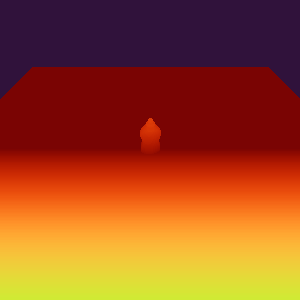

In [54]:
j.get_depth_image(np.array(ycb_img)[:, :, 3]; max=10)

In [55]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [56]:
pc = cam_pose * image_to_cloud(DepthImage(ycb_img))

3×68876 Matrix{Float32}:
  9.95897      9.89257      9.82706     …  -4.23554     -4.22341
 -0.00499916  -0.00499868  -0.00499868     -0.00500011  -0.00499964
 -4.78373     -4.65854     -4.535           5.95475      5.97779

In [57]:
j.meshcat.show_cloud("cloud", pc')

In [58]:
OBS_CLOUD_SIZE = 3000

3000

In [59]:
OUTLIER_ΔX, OUTLIER_ΔY, OUTLIER_ΔZ = 10, 10, 10

(10, 10, 10)

In [60]:
struct StochRenderer <: Distribution{DepthImage} end
stoch_render = StochRenderer()


function random(::StochRenderer, scene, cam_pose, cam_intrinsics, p_outlier, noise)
    full_cloud = render_scene_to_cloud(scene, cam_pose, cam_intrinsics)
    obs_cloud = Array{Float32, 2}(undef, 3, OBS_CLOUD_SIZE)
    outlier_idxs = findall(rand(OBS_CLOUD_SIZE) .< p_outlier)
    inlier_idxs = filter(x -> !in(x, outlier_idxs), 1:OBS_CLOUD_SIZE)
    obs_cloud[:, inlier_idxs] = full_cloud[:, rand(1:size(full_cloud, 2), length(inlier_idxs))]
    obs_cloud[:, outlier_idxs] = rand(3, length(outlier_idxs)) .* [OUTLIER_ΔX, OUTLIER_ΔY, OUTLIER_ΔZ]
    jax_normal = jax.vmap(key->jax.random.multivariate_normal(key, jnp.zeros(3), jnp.eye(3)*noise))
    noise_cloud = np.array(jax_normal(jax.random.split(jax.random.PRNGKey(3), length(inlier_idxs))))
    obs_cloud[:, inlier_idxs] += noise_cloud'
    DepthImage(np.array(j.render_point_cloud(obs_cloud', cam_intrinsics)))
end

# XXX not parallel friendly
# XXX unsound, implement different sound versions
function logpdf(::StochRenderer, depth_img, scene, cam_pose, cam_intrinsics, p_outlier, noise)
    full_cloud = render_scene_to_cloud(renderer, scene, cam_pose, cam_intrinsics)
    obs_cloud = image_to_cloud(depth_img)
    j.threedp3_likelihood_jit(full, rendered_img, [noise], p_outlier, OUTLIER_VOLUME)
end


logpdf (generic function with 26 methods)

In [61]:
dimg = random(stoch_render, ycb_scene, cam_pose, intrinsics, 1e-3, 1e-2)

Increasing frame buffer size to (width, height, depth) = (320, 320, 2048)


DepthImage([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [62]:
j.meshcat.clear()

In [63]:
pc = cam_pose * image_to_cloud(dimg)

3×2887 Matrix{Float32}:
  9.53665     9.13934     6.19016    5.62278    …  -5.12524     -4.8741
  0.0743108  -0.0832667  -0.258344  -0.0995779      0.00449133  -0.0979443
 -3.9348     -3.26994     2.08707    3.27142        4.2544       4.63745

In [64]:
j.meshcat.show_cloud("cloud", pc')